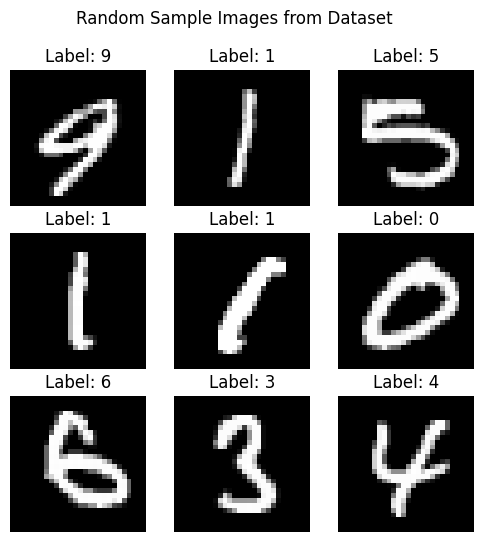

Epoch 1/25
1050/1050 [==============================] - 33s 30ms/step - loss: 0.1766 - accuracy: 0.9447 - val_loss: 0.0650 - val_accuracy: 0.9800
Epoch 2/25
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0530 - accuracy: 0.9832 - val_loss: 0.0470 - val_accuracy: 0.9848
Epoch 3/25
1050/1050 [==============================] - 18s 17ms/step - loss: 0.0354 - accuracy: 0.9882 - val_loss: 0.0493 - val_accuracy: 0.9860
Epoch 4/25
1050/1050 [==============================] - 38s 36ms/step - loss: 0.0276 - accuracy: 0.9908 - val_loss: 0.0373 - val_accuracy: 0.9879
Epoch 5/25
1050/1050 [==============================] - 18s 17ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 0.0414 - val_accuracy: 0.9865
Epoch 6/25
1050/1050 [==============================] - 27s 25ms/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.0384 - val_accuracy: 0.9883
Epoch 7/25
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0462 -

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import cv2

# Load dataset
file_path = './data.csv'
data = pd.read_csv(file_path)

# Tách nhãn và dữ liệu ảnh
X = data.iloc[:, 1:].values.reshape(-1, 28, 28, 1) / 255.0  # Reshape và chuẩn hóa
Y = data.iloc[:, 0].values.reshape(-1, 1)

# One-hot encoding nhãn
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y)

# Chia tập train/test theo tỷ lệ 80% train, 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Hiển thị 9 ảnh ngẫu nhiên từ tập dữ liệu với nhãn
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    random_idx = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[random_idx].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(Y_train[random_idx])}")
    plt.axis('off')
plt.suptitle("Random Sample Images from Dataset")
plt.show()

# Xây dựng mô hình CNN cơ bản
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình CNN
cnn_history = cnn_model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_test, Y_test))

# Resize ảnh từ 28x28 lên 32x32 cho ResNet
X_train_resnet = np.array([cv2.resize(img, (32, 32)) for img in np.repeat(X_train, 3, axis=-1)])
X_test_resnet = np.array([cv2.resize(img, (32, 32)) for img in np.repeat(X_test, 3, axis=-1)])

# Xây dựng mô hình ResNet
resnet_model = keras.applications.ResNet50(
    input_shape=(32, 32, 3),  # Đã resize lên 32x32
    include_top=False,
    weights=None
)

# Thêm các lớp đầu ra
x = layers.GlobalAveragePooling2D()(resnet_model.output)
x = layers.Dense(128, activation='relu')(x)
out = layers.Dense(10, activation='softmax')(x)
resnet_model = keras.Model(inputs=resnet_model.input, outputs=out)

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình ResNet
resnet_history = resnet_model.fit(X_train_resnet, Y_train, epochs=5, batch_size=32, validation_data=(X_test_resnet, Y_test))

# In kết quả train/test accuracy & loss
print("CNN Model: Train Accuracy =", cnn_history.history['accuracy'][-1], ", Test Accuracy =", cnn_history.history['val_accuracy'][-1])
print("CNN Model: Train Loss =", cnn_history.history['loss'][-1], ", Test Loss =", cnn_history.history['val_loss'][-1])
print("ResNet Model: Train Accuracy =", resnet_history.history['accuracy'][-1], ", Test Accuracy =", resnet_history.history['val_accuracy'][-1])
print("ResNet Model: Train Loss =", resnet_history.history['loss'][-1], ", Test Loss =", resnet_history.history['val_loss'][-1])

# So sánh kết quả
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Test Accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Comparison')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Test Loss')
plt.plot(resnet_history.history['loss'], label='ResNet Train Loss')
plt.plot(resnet_history.history['val_loss'], label='ResNet Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Comparison')

plt.show()